# Importing Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

# Data Reading

In [2]:
df = pd.read_csv("data.csv", encoding="ISO-8859-1")
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


# Data Inspection

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [4]:
df.duplicated().sum()

5268

In [5]:
df.isna().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [6]:
df.describe()

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


In [7]:
df.describe(include='object')

,InvoiceNo,StockCode,Description,InvoiceDate,Country
count,541909,541909,540455,541909,541909
unique,25900,4070,4223,23260,38
top,573585,85123A,WHITE HANGING HEART T-LIGHT HOLDER,10/31/2011 14:41,United Kingdom
freq,1114,2313,2369,1114,495478


# Data Cleaning

In [8]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

In [9]:
df = df.dropna(subset=['CustomerID'])
df['CustomerID'] = df['CustomerID'].astype(int)

In [10]:
df.dtypes

InvoiceNo              object
StockCode              object
Description            object
Quantity                int64
InvoiceDate    datetime64[ns]
UnitPrice             float64
CustomerID              int32
Country                object
dtype: object

# Feature engineering

In [11]:
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34


# RFM Metrics

In [12]:
today = df['InvoiceDate'].max() + pd.Timedelta(days=1)

rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (today - x.max()).days,  # Recency
    'InvoiceNo': 'nunique',                          # Frequency
    'TotalPrice': 'sum'                              # Monetary
}).reset_index()
rfm.columns = ['CustomerID', 'Recency', 'Frequency', 'Monetary']
rfm

,CustomerID,Recency,Frequency,Monetary
0,12346,326,2,0.00
1,12347,2,7,4310.00
2,12348,75,4,1797.24
3,12349,19,1,1757.55
4,12350,310,1,334.40
...,...,...,...,...
4367,18280,278,1,180.60
4368,18281,181,1,80.82
4369,18282,8,3,176.60
4370,18283,4,16,2094.88


In [13]:
r_labels = [5, 4, 3, 2, 1]
rfm['R_Score'] = pd.qcut(rfm['Recency'], q=5, labels=r_labels)

In [16]:
f_labels = [1, 2, 3, 4, 5]
rfm['F_Score'] = pd.qcut(rfm['Frequency'].rank(method='first'), q=5, labels=f_labels)

In [17]:
m_labels = [1, 2, 3, 4, 5]
rfm['M_Score'] = pd.qcut(rfm['Monetary'], q=5, labels=m_labels)

In [18]:
rfm['RFM_Score'] = rfm['R_Score'].astype(str) + rfm['F_Score'].astype(str) + rfm['M_Score'].astype(str)

In [19]:
rfm

,CustomerID,Recency,Frequency,Monetary,R_Score,F_Score,M_Score,RFM_Score
0,12346,326,2,0.00,1,2,1,121
1,12347,2,7,4310.00,5,4,5,545
2,12348,75,4,1797.24,2,3,4,234
3,12349,19,1,1757.55,4,1,4,414
4,12350,310,1,334.40,1,1,2,112
...,...,...,...,...,...,...,...,...
4367,18280,278,1,180.60,1,2,1,121
4368,18281,181,1,80.82,1,2,1,121
4369,18282,8,3,176.60,5,3,1,531
4370,18283,4,16,2094.88,5,5,5,555


In [20]:
def assign_segment(row):
    r = int(row['R_Score'])
    f = int(row['F_Score'])
    m = int(row['M_Score'])

    if r >= 4 and f >= 4 and m >= 4:
        return 'Champions'
    elif 2 <= r < 4 and f >= 4 and m >= 4:
        return 'Loyal Customers'
    elif r >= 4 and 2 <= f <= 3 and 2 <= m <= 4:
        return 'Potential Loyalists'
    elif r <= 2 and f >= 4 and m >= 3:
        return 'At Risk'
    elif r <= 2 and f <= 2 and m <= 2:
        return 'Hibernating'
    else:
        return 'Lost'

In [21]:
rfm['Segment'] = rfm.apply(assign_segment, axis=1)

In [23]:
rfm.head()

,CustomerID,Recency,Frequency,Monetary,R_Score,F_Score,M_Score,RFM_Score,Segment
0,12346,326,2,0.00,1,2,1,121,Hibernating
1,12347,2,7,4310.00,5,4,5,545,Champions
2,12348,75,4,1797.24,2,3,4,234,Lost
3,12349,19,1,1757.55,4,1,4,414,Lost
4,12350,310,1,334.40,1,1,2,112,Hibernating


# Visualize the Segments

C:\Users\PC\AppData\Local\Temp\ipykernel_19784\1357634436.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=rfm, x='Segment', order=rfm['Segment'].value_counts().index, palette='viridis')


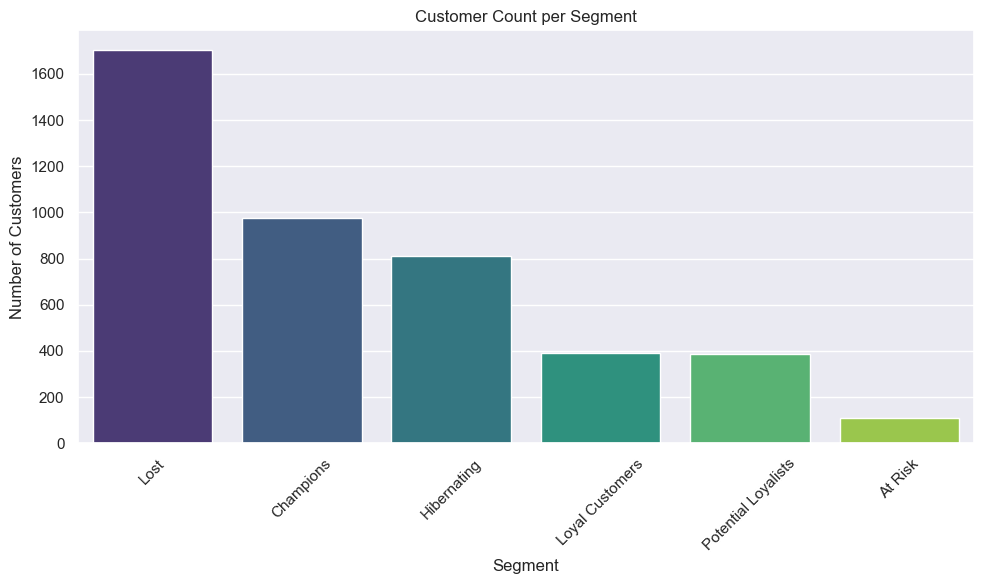

In [24]:
plt.figure(figsize=(10, 6))
sns.countplot(data=rfm, x='Segment', order=rfm['Segment'].value_counts().index, palette='viridis')
plt.title('Customer Count per Segment')
plt.xlabel('Segment')
plt.ylabel('Number of Customers')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

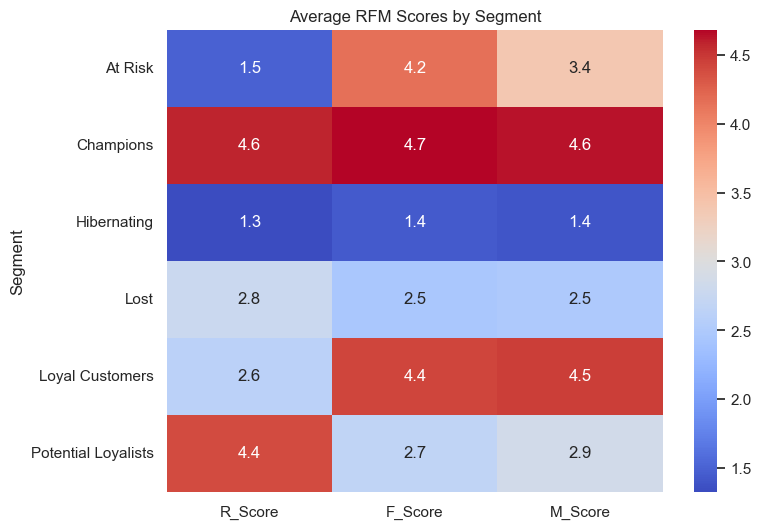

In [27]:
rfm['R_Score'] = rfm['R_Score'].astype(int)
rfm['F_Score'] = rfm['F_Score'].astype(int)
rfm['M_Score'] = rfm['M_Score'].astype(int)

segment_summary = rfm.groupby('Segment')[['R_Score', 'F_Score', 'M_Score']].mean()

plt.figure(figsize=(8, 6))
sns.heatmap(segment_summary, annot=True, cmap='coolwarm')
plt.title('Average RFM Scores by Segment')
plt.show()

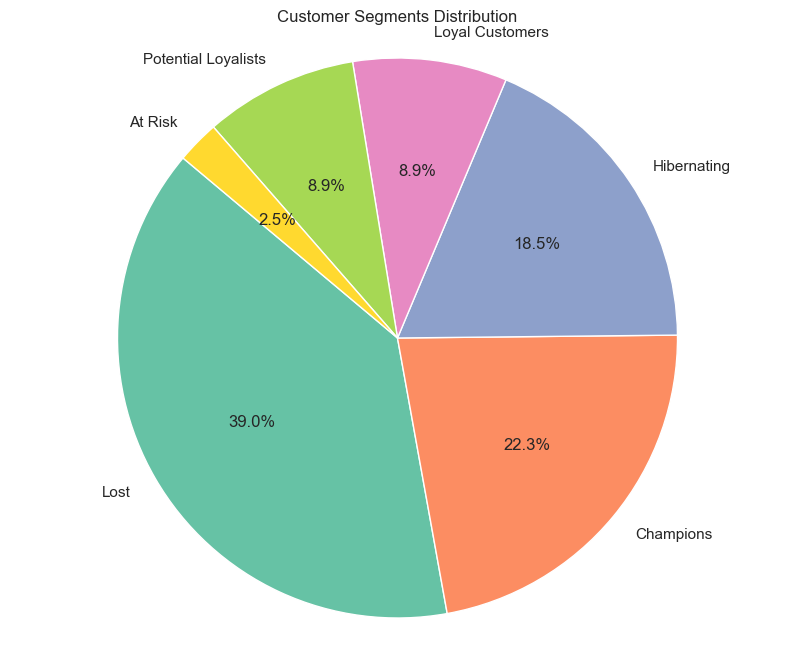

In [35]:
segment_counts = rfm['Segment'].value_counts()

plt.figure(figsize=(10, 8))
plt.pie(segment_counts, labels=segment_counts.index, autopct='%1.1f%%', startangle=140, colors=sns.color_palette('Set2'))
plt.title('Customer Segments Distribution')
plt.axis('equal')
plt.show()

# 🎯 Marketing Strategies for Each Segment

🏆 1. Champions

    ✅ Strategies:

    Give them early access to new products

    Offer exclusive loyalty rewards or VIP perks

    Ask for reviews or testimonials

    Surprise them with gifts or handwritten thank-you notes

💙 2. Loyal Customers

    ✅ Strategies:

    Offer referral bonuses to bring in friends

    Invite to loyalty programs or subscription deals

    Cross-sell or upsell based on past purchases

    Send personalized emails: "Since you liked X, you might love Y!"

🌱 3. Potential Loyalists

    ✅ Strategies:

    Welcome them warmly and offer a second-purchase discount

    Recommend popular products

    Share customer stories and social proof

    Send a follow-up email: “How was your first order?”

⚠️ 4. At Risk

    ✅ Strategies:

    Send a “We miss you!” email with a strong discount

    Offer free shipping on their next order

    Ask for feedback: “What went wrong?”

    Show what's new or improved in your shop

💤 5. Hibernating

    ✅ Strategies:

    Send seasonal or flash-sale emails

    Offer a reactivation coupon

    Create a “You’re missing out!” campaign

    Give them a chance to update preferences or unsubscribe

❌ 6. Lost

    ✅ Strategies:

    One last reactivation campaign (with a big offer or survey)

    Ask: “Still want to hear from us?”

    If no response: remove them to save email costs & improve open rate